In [ ]:
#*****************************************************************************************************************************
#Project   : Advance AI                                                                                                     #
#Author    : Nishank Singhal                                                                                                #
#Objective : The Main Objective of the project is to demonstrate the Q-Learning Model in finding the optimal path to reach   #
#the Goal State from any particular state in the Environment                                                                 #
#Approach  : 1)Design the path Grid(for Visualization)                                                                       #
#            2)Build Reward Matrix                                                                                           #
#            3)Build Q-Learning Model using Bellmen Equation                                                                 #
#            4)Build Q-Learning Model using Heuristic Fuction                                                                #
#            5)Compare the Perfomance of Both models                                                                         #
#            6)Evaluate the Metrics of the Q-Lerning Models                                                                  #
#****************************************************************************************************************

In [1]:
import os
import time
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import gymnasium as gym
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3", render_mode="ansi")

Episode: 100000
Training finished.



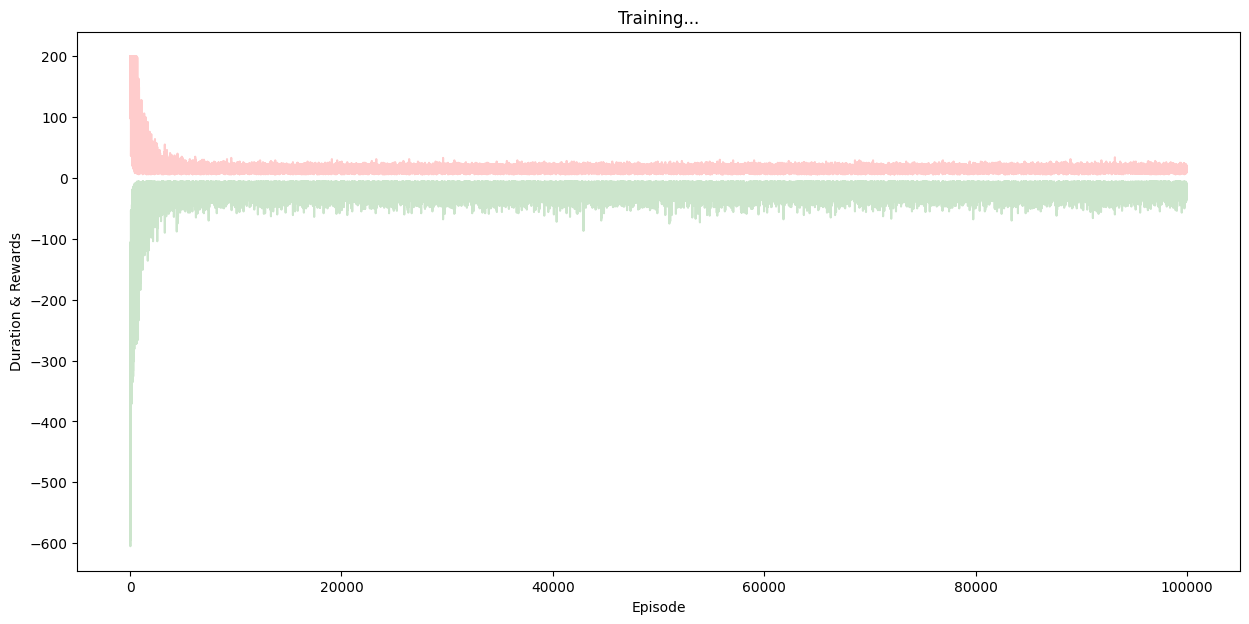

In [3]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state, info = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, terminated, truncated, _ = env.step(action) 
        
        done = terminated or truncated
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward < 0:
            penalties += reward

        state = next_state
        epochs += 1
        
    all_penalties.append(penalties)
    all_epochs.append(epochs)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")


print("Training finished.\n")
fig = plt.figure(1, figsize=(15, 7))
plt.clf()
ax1 = fig.add_subplot(111)

plt.title('Training...')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Duration & Rewards')
ax1.plot(all_epochs, label='Duration', alpha=0.2, color='r')
ax1.plot(all_penalties, label='Rewards', alpha=0.2, color='g')

In [4]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for i in range(episodes):
    state, info = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        state = next_state

        done = terminated or truncated

        if reward < 0:
            penalties += reward

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs
    
    

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.86
Average penalties per episode: -11.86


In [30]:
import time
import matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
actions_str = ["South", "North", "East", "West", "Pickup", "Dropoff"]

iteration = 0
state, info = env.reset()  # reset environment to a new, random state
env.render()
time.sleep(0.02)
terminated = False

while not terminated:
    action = np.argmax(q_table[state])
    iteration += 1
    state, reward, terminated, truncated, _ = env.step(action.item())
    display.clear_output(wait=True)
    print(env.render())
    print(f"Iter: {iteration} - Action: {action}({actions_str[action]}) - Reward {reward}")
    time.sleep(0.5)
    if iteration == 200:
        print("cannot converge :(")
        break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iter: 12 - Action: 5(Dropoff) - Reward 20


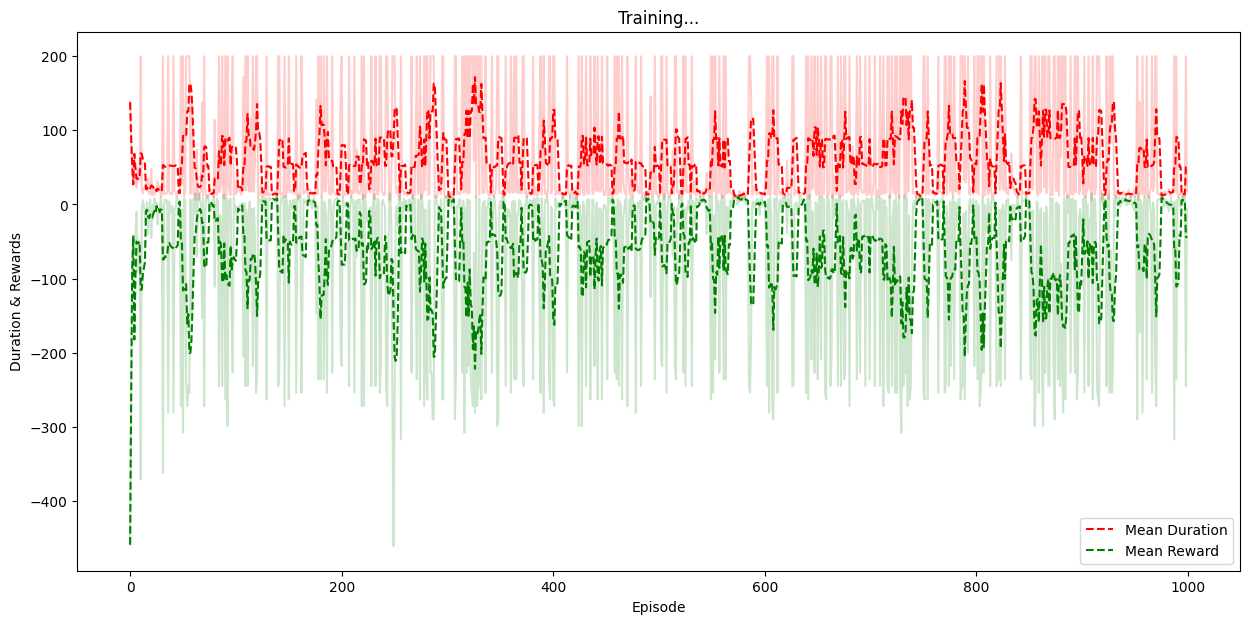

In [10]:
env = gym.make("Taxi-v3", render_mode="ansi")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.rng = np.random.default_rng()

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        idx = self.rng.choice(np.arange(len(self.memory)), batch_size, replace=False)
        res = []
        for i in idx:
            res.append(self.memory[i])
        return res

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.embedding = nn.Embedding(n_observations, 4)
        self.layer1 = nn.Linear(4, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x): 
        x = F.relu(self.layer1(self.embedding(x)))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 400
TAU = 0.005
LR = 1e-3
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()

# Number of observations is the number of states Taxi-v3 has 500
n_observations = env.observation_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

if os.path.isfile('policy_net.pth'):
    policy_net.load_state_dict(torch.load('policy_net.pth'))
    print('Load policy_net.pth')
    
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def get_action_for_state(state):
    with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        predicted = policy_net(torch.tensor([state], device=device))
        action = predicted.max(1)[1]
    return action

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    if sample > eps_threshold:
        return get_action_for_state(state)
    else:
        return env.action_space.sample()


episode_durations = []
reward_history = []
epsilons = []

def _moving_average(x, periods=5):
    if len(x) < periods:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    res = (cumsum[periods:] - cumsum[:-periods]) / periods
    return np.hstack([x[:periods-1], res])


def plot_durations():
    lines = []
    fig = plt.figure(1, figsize=(15, 7))
    plt.clf()
    ax1 = fig.add_subplot(111)

    plt.title('Training...')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Duration & Rewards')
    ax1.plot(episode_durations, label='Duration', alpha=0.2, color='r')
    ax1.plot(reward_history, label='Rewards', alpha=0.2, color='g')
    
    mean_steps = _moving_average(episode_durations)
    mean_reward = _moving_average(reward_history)
    
    lines.append(ax1.plot(mean_steps, color='r', linestyle='--', label='Mean Duration')[0])
    lines.append(ax1.plot(mean_reward, color='g', linestyle='--', label='Mean Reward')[0])
    
    ax1.legend(lines, [l.get_label() for l in lines])

    if is_ipython:
        display.clear_output(wait=True)
    else:
        plt.show()
    
    plt.pause(0.001)    

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
   
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(next_state_batch).max(1)[0]
        
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

if torch.cuda.is_available():
    num_episodes = 3000
else:
    num_episodes = 1500

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    reward_in_episode = 0
    
    for t in count():
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        reward_in_episode += reward
        # Store the transition in memory
        memory.push(
            torch.tensor([state], device=device), 
            torch.tensor([action], device=device, dtype=torch.long),
            torch.tensor([next_state], device=device), 
            torch.tensor([reward], device=device),
        )

        # Move to the next state
        done = terminated or truncated
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            reward_history.append(reward_in_episode)
            epsilons.append(EPS_END + (EPS_START - EPS_END) * math.exp(-i_episode / EPS_DECAY))
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations()
plt.ioff()
plt.show()

torch.save(policy_net.state_dict(), 'policy_net.pth')

In [31]:
checkpoint = torch.load('policy_net.pth')
policy_net.load_state_dict(checkpoint)

actions_str = ["South", "North", "East", "West", "Pickup", "Dropoff"]

iteration = 0
state, info = env.reset()  # reset environment to a new, random state
env.render()
time.sleep(0.02)
terminated = False

while not terminated:
    action = get_action_for_state(state)
    iteration += 1
    state, reward, terminated, truncated, _ = env.step(action.item())
    display.clear_output(wait=True)
    print(env.render())
    print(f"Iter: {iteration} - Action: {action}({actions_str[action]}) - Reward {reward}")
    time.sleep(0.5)
    if iteration == 200:
        print("cannot converge :(")
        break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iter: 9 - Action: tensor([5])(Dropoff) - Reward 20


In [15]:
# Tic-Tac-Tao

In [16]:
import numpy as np
import pickle

# Initialize the number of rows and columns
NUMBER_OF_COLUMNS = 3
NUMBER_OF_ROWS = 3

In [17]:
class Player:

    # Default constructor
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.exp_rate = exp_rate
        # List to record all the positions taken
        self.states = []
        self.decay_gamma = 0.9
        self.lr = 0.2
        self.states_value = {}  # dict to map state to value

    # Method to decide which action to take further
    def decideAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # Choose a random action , random index
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            # Iterate over all possible positions
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        return action

    # Function to get the hash value of board
    def getHash(self, board):
        boardHash = str(board.reshape(NUMBER_OF_COLUMNS * NUMBER_OF_ROWS))
        return boardHash

    # Function to reset states
    def reset(self):
        self.states = []

    # Function to provide reward to the model
    # As the game ends, backpropagate and update state value
    def feedReward(self, reward):
        # Reverse iterate over states
        for st in reversed(self.states):
            # If state is null
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            # Calculate state value
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    # Append a hash state to state
    def addState(self, state):
        self.states.append(state)

    # Function to load Policy for the Player, as a Pickle file
    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

    # Function to save Policy for the Player, as a Pickle file
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()


In [18]:

# Class for Human Player
class HumanPlayer:

    # Default constructor
    def __init__(self, name):
        self.name = name

    # Method to choose which action to take further
    def decideAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

    # Method to reset the states
    def reset(self):
        pass # Method does not validate for human beings

    # As the game ends, backpropagate and update state value
    def feedReward(self, reward):
        pass # Method does not validate for human beings

    # Append the state
    def addState(self, state):
        pass # Method does not validate for human beings


In [19]:

# Class for State
class State:

    # Default constructor
    def __init__(self, p1, p2):
        self.board = np.zeros((NUMBER_OF_ROWS, NUMBER_OF_COLUMNS))
        self.p1 = p1
        self.p2 = p2
        self.playerSymbol = 1
        self.boardHash = None
        self.isEnd = False

    # Function to get the hash value of board
    def getHash(self):
        self.boardHash = str(self.board.reshape(NUMBER_OF_COLUMNS * NUMBER_OF_ROWS))
        return self.boardHash

    # Check and return available positions
    def availablePositions(self):
        positions = []
        for i in range(NUMBER_OF_ROWS):
            for j in range(NUMBER_OF_COLUMNS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    # Declare winner
    def winner(self):
        # Scan rows for winner
        for i in range(NUMBER_OF_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # Scan cols for winner
        for i in range(NUMBER_OF_COLUMNS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # Scan diagonals for winner
        diag_sum1 = sum([self.board[i, i] for i in range(NUMBER_OF_COLUMNS)])
        diag_sum2 = sum([self.board[i, NUMBER_OF_COLUMNS - i - 1] for i in range(NUMBER_OF_COLUMNS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        # If diagonal is occupied by same player
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1
        # Condition for Game Tie
        # No more available positions left
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # Game has not yet ended
        self.isEnd = False
        return None

    # Function to reset the board
    def reset(self):
        self.board = np.zeros((NUMBER_OF_ROWS, NUMBER_OF_COLUMNS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    # Give reward at the end of the game
    def giveReward(self):
        # Get winner
        result = self.winner()
        # Backpropagate Reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    # Function to update the state
    def updateState(self, position):
        # Lock position for player
        self.board[position] = self.playerSymbol
        # Switch turns between players
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # Function to play a game
    def play(self, rounds=100):
        # Iterate over those number of rounds
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            # Play until end state is not yet achieved
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.decideAction(positions, self.board, self.playerSymbol)
                # Decide an action and upate the board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)

                # Check the current board status if it is end
                win = self.winner()
                if win is not None:
                    # Ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break
                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.decideAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    # Play against human
    def play2(self):
        while not self.isEnd:
            # Player 1's turn
            positions = self.availablePositions()
            p1_action = self.p1.decideAction(positions, self.board, self.playerSymbol)
            # Decide an action and upate the board state
            self.updateState(p1_action)
            self.showBoard()

            # Check the current board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.decideAction(positions)

                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

    # Function to display the current board status
    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, NUMBER_OF_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, NUMBER_OF_COLUMNS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')


In [24]:
if __name__ == "__main__":
    # Training phase
    p1 = Player("p1")
    p2 = Player("p2")

    st = State(p1, p2)
    print("training...")
    # Train the model using 50000 random games
    st.play(50000)
    p1.savePolicy()
    p2.savePolicy()
    

training...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


In [25]:
# Play against human
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()

-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Input your action row:1
Input your action col:1
-------------
| x |   |   | 
-------------
|   | o |   | 
-------------
|   |   |   | 
-------------
-------------
| x |   |   | 
-------------
|   | o |   | 
-------------
| x |   |   | 
-------------
Input your action row:1
Input your action col:0
-------------
| x |   |   | 
-------------
| o | o |   | 
-------------
| x |   |   | 
-------------
-------------
| x |   |   | 
-------------
| o | o | x | 
-------------
| x |   |   | 
-------------
Input your action row:0
Input your action col:1
-------------
| x | o |   | 
-------------
| o | o | x | 
-------------
| x |   |   | 
-------------
-------------
| x | o |   | 
-------------
| o | o | x | 
-------------
| x | x |   | 
-------------
Input your action row:2
Input your action col:2
-------------
| x | o |   | 
-------------
| o | o | x | 
-------------
| x | x | o | 
-------------
